In [ ]:
import pandas as pd
import os

### Carregando o dataset utilizado

In [ ]:
!pip install datasets

In [ ]:
from datasets import load_dataset
dataset = load_dataset("cnn_dailymail", "3.0.0")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


### Criando o dataframe

In [ ]:
# Convertendo o split de treino para um DataFrame
df_train = pd.DataFrame(dataset['train'])

# Se quiser unir treino + validação + teste (opcional)
df_val = pd.DataFrame(dataset['validation'])
df_test = pd.DataFrame(dataset['test'])

# Junta tudo em um único DataFrame
df = pd.concat([df_train, df_val, df_test], ignore_index=True)

# Renomeia a coluna 'highlights' para 'summary'
df.rename(columns={'highlights': 'summary'}, inplace=True)

# Dataset para testes
df_final_testes = pd.concat([df_train, df_val, df_test], ignore_index=True)
df_final_testes.rename(columns={'highlights': 'summary'}, inplace=True)

# Mostra algumas amostras

print(df.columns)
df.head()

Index(['article', 'summary', 'id'], dtype='object')


,article,summary,id
0,"LONDON, England (Reuters) -- Harry Potter star...",Harry Potter star Daniel Radcliffe gets £20M f...,42c027e4ff9730fbb3de84c1af0d2c506e41c3e4
1,Editor's note: In our Behind the Scenes series...,Mentally ill inmates in Miami are housed on th...,ee8871b15c50d0db17b0179a6d2beab35065f1e9
2,"MINNEAPOLIS, Minnesota (CNN) -- Drivers who we...","NEW: ""I thought I was going to die,"" driver sa...",06352019a19ae31e527f37f7571c6dd7f0c5da37
3,WASHINGTON (CNN) -- Doctors removed five small...,"Five small polyps found during procedure; ""non...",24521a2abb2e1f5e34e6824e0f9e56904a2b0e88
4,(CNN) -- The National Football League has ind...,"NEW: NFL chief, Atlanta Falcons owner critical...",7fe70cc8b12fab2d0a258fababf7d9c6b5e1262a


In [ ]:
# Selecionando 40 mil amostras
print(df.shape)
df = df.sample(n=40000, random_state=42)
print(df.shape)

(311971, 3)
(40000, 3)


### Tokenizando os dados

In [ ]:
import nltk
from nltk.tokenize import word_tokenize
import numpy as np

nltk.download('punkt_tab')

df['text_tokenizado'] = df['article'].apply(lambda x: ['<start>'] + word_tokenize(x.lower()) + ['<end>'])
df['summary_tokenizado'] = df['summary'].apply(lambda x: ['<start>'] + word_tokenize(x.lower()) + ['<end>'])

df.head()

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


,article,summary,id,text_tokenizado,summary_tokenizado
214346,Former Manchester United striker Michael Owen ...,Manchester United have won six of their last s...,a58b45d8f3cb1466b3da41bc32c735ca80e95182,"[<start>, former, manchester, united, striker,...","[<start>, manchester, united, have, won, six, ..."
215595,Roy Hodgson will host a dinner for his England...,Roy Hodgson will assemble his England squad fo...,205d3a9f95e5ce8699ad05cdb1b5637d0a8a4163,"[<start>, roy, hodgson, will, host, a, dinner,...","[<start>, roy, hodgson, will, assemble, his, e..."
136749,"By . Ryan Gorman . PUBLISHED: . 13:24 EST, 29 ...","Kontue Johnson, 21, was shot at least 14 times...",cb1ce04f821848c70f0c4865a65e9a27afc9f400,"[<start>, by, ., ryan, gorman, ., published, :...","[<start>, kontue, johnson, ,, 21, ,, was, shot..."
45878,(Martha Stewart Living) -- It is incredible ho...,Martha Stewart wanted to make child-safe decor...,576795a50c4edc651bfe6412faaf2f612a532f72,"[<start>, (, martha, stewart, living, ), --, i...","[<start>, martha, stewart, wanted, to, make, c..."
56340,(CNN) -- Former Argentina coach Diego Maradona...,Diego Maradona will be the new coach of Dubai-...,09c8329cd1b793b9373d87140ca1fd9f2a762f8d,"[<start>, (, cnn, ), --, former, argentina, co...","[<start>, diego, maradona, will, be, the, new,..."


In [ ]:
all_tokens = []
for tokens in df['text_tokenizado']:
  all_tokens.extend(tokens)

print(f'Quantidade de tokens: {len(all_tokens)}')

Quantidade de tokens: 31579842


In [ ]:
from collections import Counter
counter = Counter(all_tokens)
print(counter.most_common(10))

[('the', 1567054), ('.', 1482894), (',', 1276374), ('to', 751587), ('a', 673486), ('and', 644329), ('of', 635139), ('in', 570873), ('was', 268968), ('that', 261692)]


In [ ]:
vocabulario = [token for token, i in counter.items() if i >= 2]
vocabulario = ['<unk>'] + vocabulario
print(f'Quantidade de tokens no vocabulario: {len(vocabulario)}')
print(vocabulario[:10])
tamanho_vocabulario = len(vocabulario)

Quantidade de tokens no vocabulario: 155884
['<unk>', '<start>', 'former', 'manchester', 'united', 'striker', 'michael', 'owen', 'has', 'warned']


### Vetorizando os dados

In [ ]:
dict_token2id = {token: i for i, token in enumerate(vocabulario)}
def token2id(tokens):
  return [dict_token2id.get(token, 0) for token in tokens]

# Dicionário reverso para converter IDs em palavras
id2token = {i: token for token, i in dict_token2id.items()}

df['text_token_id'] = df['text_tokenizado'].apply(token2id)
df['summary_token_id'] = df['summary_tokenizado'].apply(token2id)


# Funçao para padronizar o tamanho dos textos e dos resumos, garantindo que o token '<end>' esteja no final
def ajustar_sequencia(seq, limite):
    end_token = dict_token2id['<end>']

    if len(seq) <= limite:
        return seq  # não precisa cortar
    if end_token in seq[:limite]: # se o end já está na sequencia cortada
      return seq[:limite]
    else:
      return seq[:limite-1] + [end_token]

df['text_token_id'] = df['text_token_id'].apply(lambda x: ajustar_sequencia(x, 500))
df['summary_token_id'] = df['summary_token_id'].apply(lambda x: ajustar_sequencia(x, 60))

In [ ]:
from sklearn import model_selection
from tensorflow.keras.preprocessing.sequence import pad_sequences

### Criando as entradas do encoder e decoder. Separando os dados em treinamento e validacao

In [ ]:

# Entrada do decoder: resumo sem o token <end>
df['decoder_input'] = df['summary_token_id'].apply(lambda x: x[:-1])

# Saída do decoder: resumo sem o token <start>
df['decoder_output'] = df['summary_token_id'].apply(lambda x: x[1:])

max_len_text = max(df['text_token_id'].apply(len))
max_len_summary = max(df['summary_token_id'].apply(len))  # serve para input e output


"""Apesar das sequências originais de texto e resumo terem sido previamente ajustadas para um comprimento fixo, a criação das entradas e
saídas do decoder (que removem os tokens <start> e <end>, respectivamente) faz com que essas novas sequências tenham tamanhos variados.
Para garantir que não há problemas, aplicou-se o zero padding"""

# Padding
X_encoder = pad_sequences(df['text_token_id'], maxlen=max_len_text, padding='post')
y_decoder_input = pad_sequences(df['decoder_input'], maxlen=max_len_summary-1, padding='post')
y_decoder_output = pad_sequences(df['decoder_output'], maxlen=max_len_summary-1, padding='post')

vocab_size_target = tamanho_vocabulario + 1 # para o caractere do padding

X_enc_train, X_enc_val, y_dec_in_train, y_dec_in_val, y_dec_out_train, y_dec_out_val = model_selection.train_test_split(
    X_encoder, y_decoder_input, y_decoder_output, test_size=0.2, random_state=42)

In [ ]:
!pip install keras-nlp

### Arquitetura do Modelo

In [ ]:
import keras_nlp
from tensorflow.keras.layers import Input, Embedding, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Hiperparâmetros
embedding_dim = 128
num_heads = 4
ff_dim = 512
num_layers = 2

# Input e vocabulário
encoder_inputs = Input(shape=(None,), dtype='int32', name='encoder_inputs')
decoder_inputs = Input(shape=(None,), dtype='int32', name='decoder_inputs')

# Embedding compartilhado
embedding_layer = Embedding(input_dim=tamanho_vocabulario, output_dim=embedding_dim, mask_zero=True)

# Aplica embedding
x_enc = embedding_layer(encoder_inputs)
x_dec = embedding_layer(decoder_inputs)

# Transformer Encoder
for i in range(num_layers):
    x_enc = keras_nlp.layers.TransformerEncoder(
        intermediate_dim=ff_dim,
        num_heads=num_heads,
        dropout=0.1,
        activation="relu",
        name=f"encoder_layer_{i}"
    )(x_enc)

# Transformer Decoder
for i in range(num_layers):
    x_dec = keras_nlp.layers.TransformerDecoder(
        intermediate_dim=ff_dim,
        num_heads=num_heads,
        dropout=0.1,
        activation="relu",
        name=f"decoder_layer_{i}"
    )(decoder_sequence=x_dec, encoder_sequence=x_enc)

# Saída final
output = Dense(tamanho_vocabulario, activation="softmax")(x_dec)

#Model Checkpoint
mc = ModelCheckpoint('best_model_NLTK_v2.keras', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=5)

# Modelo final
model = Model([encoder_inputs, decoder_inputs], output)
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ decoder_inputs      │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_inputs      │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, None, 128) │ 19,953,152 │ encoder_inputs[0… │
│ (Embedding)         │                   │            │ decoder_inputs[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_layer_0     │ (None, None, 128) │    198,272 │ embedding[0][0]   │
│ (TransformerEncode… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_layer_1     │ (None, None, 128) │    198,272 │ encoder_layer_0[… │
│ (TransformerEncode… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_layer_0     │ (None, None, 128) │    264,576 │ embedding[1][0],  │
│ (TransformerDecode… │                   │            │ encoder_layer_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_layer_1     │ (None, None, 128) │    264,576 │ decoder_layer_0[… │
│ (TransformerDecode… │                   │            │ encoder_layer_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, None,      │ 20,109,036 │ decoder_layer_1[… │
│                     │ 155884)           │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 40,987,884 (156.36 MB)

 Trainable params: 40,987,884 (156.36 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(
    [X_encoder, y_decoder_input],   # entradas: texto completo + resumo com <start>
    y_decoder_output,               # saída: resumo com <end> (como inteiros, sem one-hot)
    batch_size=64,
    epochs=250,
    validation_data=([X_enc_val, y_dec_in_val], y_dec_out_val),
    callbacks=[es, mc]
)

Epoch 1/250


/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'query' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'key' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'value' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.0862 - loss: 7.6331
Epoch 1: val_accuracy improved from -inf to 0.15587, saving model to /content/drive/MyDrive/Projeto Final Deep Learning/best_model_NLTK.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 116s 75ms/step - accuracy: 0.0863 - loss: 7.6318 - val_accuracy: 0.1559 - val_loss: 5.7864
Epoch 2/250
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.1555 - loss: 5.7345
Epoch 2: val_accuracy improved from 0.15587 to 0.18432, saving model to /content/drive/MyDrive/Projeto Final Deep Learning/best_model_NLTK.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 38s 61ms/step - accuracy: 0.1555 - loss: 5.7344 - val_accuracy: 0.1843 - val_loss: 5.1119
Epoch 3/250
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.1810 - loss: 5.1352
Epoch 3: val_accuracy improved from 0.18432 to 0.20409, saving model to /content/drive/MyDrive/Projeto Final Deep Learning/best_model_NLTK.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 38s 62ms/step - accuracy: 0.1810 - loss: 5.1352 

### Carregando o modelo treinado

In [ ]:
from tensorflow.keras.models import load_model
model = load_model('best_model_NLTK.keras')

### Graficos de acuracia e perda

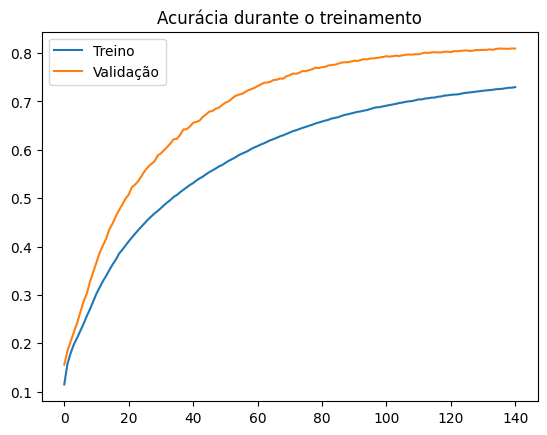

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Treino')
plt.plot(history.history['val_accuracy'], label='Validação')
plt.legend()
plt.title('Acurácia durante o treinamento')
plt.show()


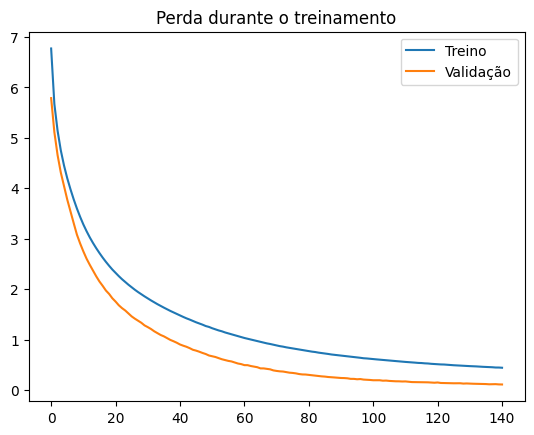

In [ ]:
plt.plot(history.history['loss'], label='Treino')
plt.plot(history.history['val_loss'], label='Validação')
plt.legend()
plt.title('Perda durante o treinamento')
plt.show()

### Funções para preparar novos textos e gerar resumos

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

def preparar_texto_para_inferencia(texto, dict_token2id, max_len_text):
    """
    Converte um texto (string) em uma sequência de IDs com padding,
    seguindo o mesmo pré-processamento feito no treino.
    """
    # 1. Tokeniza, adiciona <start> e <end>, e coloca tudo em minúsculo
    tokens = ['<start>'] + word_tokenize(texto.lower()) + ['<end>']

    # 2. Converte tokens em IDs usando seu vocabulário
    token_ids = [dict_token2id.get(token, dict_token2id['<unk>']) for token in tokens]

    # 3. Ajusta a sequência ao limite, mantendo <end> no final
    end_token = dict_token2id['<end>']
    if len(token_ids) > max_len_text:
        if end_token in token_ids[:max_len_text]:
            token_ids = token_ids[:max_len_text]
        else:
            token_ids = token_ids[:max_len_text-1] + [end_token]

    # 4. Aplica padding para garantir o shape correto
    token_ids_padded = pad_sequences([token_ids], maxlen=max_len_text, padding='post')

    return token_ids_padded

In [ ]:
def decode_transformer(input_seq, max_len=50):
    # Começa com o token <start>
    decoded_sentence = [dict_token2id['<start>']]

    for _ in range(max_len):
        decoder_input = np.array([decoded_sentence])  # (1, current_length)

        # Previsão com input do encoder e sequência parcial do decoder
        preds = model.predict([input_seq, decoder_input], verbose=0)

        next_token = np.argmax(preds[0, -1, :])
        next_word = id2token.get(next_token, '<unk>')

        if next_word == '<end>':
            break

        decoded_sentence.append(next_token)

    decoded_words = [id2token.get(i, '') for i in decoded_sentence[1:]]  # remove <start>
    return ' '.join(decoded_words)


In [ ]:
def decode_transformer_sampling(input_seq, max_len=50, top_k=5):
    decoded_sentence = [dict_token2id['<start>']]

    for _ in range(max_len):
        decoder_input = np.array([decoded_sentence])

        # Gera a distribuição de probabilidade para o próximo token
        preds = model.predict([input_seq, decoder_input], verbose=0)
        logits = preds[0, -1, :]  # última posição da sequência

        # Pega os top_k tokens com maior probabilidade
        top_k_indices = np.argpartition(logits, -top_k)[-top_k:]
        top_k_probs = logits[top_k_indices]
        top_k_probs = np.exp(top_k_probs) / np.sum(np.exp(top_k_probs))  # softmax normalizado

        # Escolhe aleatoriamente entre os top_k
        next_token = np.random.choice(top_k_indices, p=top_k_probs)

        next_word = id2token.get(next_token, '<unk>')
        if next_word == '<end>':
            break

        decoded_sentence.append(next_token)

    decoded_words = [id2token.get(i, '') for i in decoded_sentence[1:]]  # remove <start>
    return ' '.join(decoded_words)

In [ ]:
import numpy as np
import heapq

def decode_transformer_beam_search(input_seq, max_len=50, beam_width=3):
    start_token_id = dict_token2id['<start>']
    end_token_id = dict_token2id['<end>']

    # Beam é uma lista de tuplas: (pontuação_log, sequência)
    beam = [(0.0, [start_token_id])]

    for _ in range(max_len):
        new_beam = []

        for score, seq in beam:
            if seq[-1] == end_token_id:
                # Se já terminou, mantém como está
                new_beam.append((score, seq))
                continue

            decoder_input = np.array([seq])
            preds = model.predict([input_seq, decoder_input], verbose=0)
            probs = preds[0, -1, :]  # últimas probabilidades

            # Pegamos os top beam_width candidatos
            top_ids = np.argsort(probs)[-beam_width:]

            for token_id in top_ids:
                token_prob = probs[token_id]
                if token_prob > 0:
                    # Calcula novo score (soma de log-probs)
                    new_score = score + np.log(token_prob)
                    new_seq = seq + [token_id]
                    new_beam.append((new_score, new_seq))

        # Seleciona os beam_width melhores candidatos
        beam = sorted(new_beam, key=lambda x: x[0], reverse=True)[:beam_width]

    # Pega a sequência com maior pontuação
    final_seq = beam[0][1]

    # Converte para texto (pulando o <start> e parando no <end>)
    decoded_tokens = []
    for token_id in final_seq[1:]:  # pula <start>
        if token_id == end_token_id:
            break
        decoded_tokens.append(id2token.get(token_id, ''))

    return ' '.join(decoded_tokens)


### Testando o modelo

In [ ]:
input_seq = X_encoder[7].reshape(1, -1)  # Garante que está no formato (1, sequência)
pred_summary = decode_transformer(input_seq, 50)  # Função de geração com Transformer
pred_summary_2 = decode_transformer_sampling(input_seq, 50)  # Função de geração com Transformer com sampling
pred_summary_3 = decode_transformer_beam_search(input_seq, 50)  # Função de geração com Transformer com beam search

print('Texto Original:')
for id in X_encoder[7]:
    print(id2token[id], end=' ')

print('\nResumo Original:')
for id in y_decoder_input[7]:
    print(id2token[id], end=' ')

print('\nResumo Gerado:')
print(pred_summary)

print('\nResumo Gerado com Sampling:')
print(pred_summary_2)

print('\nResumo Gerado com Beam Search:')
print(pred_summary_3)


Texto Original:
<start> kandahar , afghanistan ( cnn ) -- the soldiers had barely arrived in iraq before they got new orders -- get ready for afghanistan . a soldier waits in baghdad for a flight to his new mission in kandahar . the 4th engineer battalion out of colorado springs , colorado , deployed to camp victory near baghdad in mid-february . two weeks after the unit began actually going out on operations in iraq , it was ordered to redeploy to kandahar in afghanistan . the soldiers had n't even finished painting their emblem outside their tactical operations command when the move began . but even as he walked through the stripped-down post , battalion commander lt. col. kevin landers could not hold back his excitement . `` the president has asked our military and our country to shift the focus and bolster the effort in afghanistan , and we are really spearheading some of that effort , so of course there is some excitement here , '' he said outside a building being cleared out . th

In [ ]:
novo_texto = "Christopher Nolan’s Interstellar is a visually stunning, emotionally profound, and intellectually ambitious film that delves into the mysteries of space, time, and human resilience. Released in 2014, the film presents a future where Earth is no longer able to sustain life. Dust storms ravage the land, crops are failing, and the human population is slowly dwindling. Amidst this global crisis, a team of astronauts embarks on a journey through a wormhole in search of a new habitable planet. At the heart of the story is Cooper, a former NASA pilot turned farmer, played by Matthew McConaughey. He is a father torn between staying with his children and the urgent need to help save humanity. When the opportunity arises to join a secret space mission, he reluctantly accepts, leaving behind his young daughter Murph, whose emotional connection to her father drives much of the film’s narrative power. One of Interstellar's most compelling elements is its exploration of time. Due to the effects of relativity, time passes differently for those traveling near a black hole compared to those remaining on Earth. This results in heartbreaking consequences, particularly for Cooper, who watches years pass by for his children while only experiencing hours or days himself. The film’s treatment of time is both scientifically inspired and deeply poetic, raising profound questions about memory, aging, and the nature of human connection. The science behind the film is grounded in real physics, thanks in part to the involvement of theoretical physicist Kip Thorne, who served as an executive producer and scientific consultant. Concepts such as wormholes, time dilation, and gravitational anomalies are woven into the story in a way that challenges audiences without alienating them. While some liberties are taken for dramatic effect, the film remains one of the most scientifically thoughtful space adventures in cinematic history. Visually, Interstellar is a masterpiece. The depiction of the black hole Gargantua, with its glowing accretion disk, has become iconic. The barren, icy planets, the colossal waves on a water world, and the infinite expanse of space are rendered with breathtaking realism. Hans Zimmer’s haunting, organ-driven score adds emotional depth and grandeur to the visuals, heightening the film’s sense of awe and existential wonder. Beyond its scientific and visual achievements, Interstellar is ultimately a human story. It is about love as a force that transcends dimensions, about sacrifice, hope, and the indomitable will to survive. The relationship between Cooper and Murph forms the emotional core of the film, culminating in a powerful reunion that speaks to the enduring bond between parent and child. In conclusion, Interstellar is not just a science fiction film; it is a cinematic experience that challenges the mind and stirs the soul. With its blend of cutting-edge science, philosophical inquiry, and emotional storytelling, it continues to captivate and inspire audiences around the world."
texto_tokenizado = preparar_texto_para_inferencia(novo_texto, dict_token2id, 500)
print(texto_tokenizado, len(texto_tokenizado[0]))

[[     1   2628  10187    145    146  31439     16     29  18228   5656
      53  16217  17107     53     34  39161  13850   2935     13  51808
      40     17  15122     31   4560     53    412     53     34   8010
   10381     23   3090     42    165     53     17   2935   9056     29
    2470    171    674     16    468   1212    564     83  13480    497
      23   9817   6515 106128     17   1291     53  30100    215   8991
      53     34     17   8010   1036     16   5408  15768     23  13849
      21   1128   6167     53     29    143     31   7542  33052     72
      29   5803    359     29 140565     42    489     31     29    109
   26056   3309     23    137     17   1689     31     17   1841     16
   14716     53     29      2  16121  12895   2465   2587     53    779
      93   1323  12182     23    185     16     29    334  19523     76
     987     67    134    561     34     17   8788   1808     83    629
    1965   6895     23    346     17   2077  25753     83   2744

In [ ]:
resumo = decode_transformer(texto_tokenizado, 50)
print("texto original:")
print(novo_texto)
print("\nresumo gerado:")
print(resumo)

texto original:
Christopher Nolan’s Interstellar is a visually stunning, emotionally profound, and intellectually ambitious film that delves into the mysteries of space, time, and human resilience. Released in 2014, the film presents a future where Earth is no longer able to sustain life. Dust storms ravage the land, crops are failing, and the human population is slowly dwindling. Amidst this global crisis, a team of astronauts embarks on a journey through a wormhole in search of a new habitable planet. At the heart of the story is Cooper, a former NASA pilot turned farmer, played by Matthew McConaughey. He is a father torn between staying with his children and the urgent need to help save humanity. When the opportunity arises to join a secret space mission, he reluctantly accepts, leaving behind his young daughter Murph, whose emotional connection to her father drives much of the film’s narrative power. One of Interstellar's most compelling elements is its exploration of time. Due to 

In [ ]:
novo_texto = "Bitcoin is a decentralized digital currency that has transformed the way people think about money, finance, and trust. Introduced in 2009 by the pseudonymous creator Satoshi Nakamoto, Bitcoin emerged in the aftermath of the 2008 financial crisis as a response to the perceived flaws in the traditional banking system. It operates on a peer-to-peer network, allowing users to send and receive payments without the need for intermediaries such as banks or governments. At its core, Bitcoin relies on blockchain technology—a distributed public ledger that records every transaction ever made on the network. This ledger is maintained by a decentralized network of computers (called nodes) around the world. Each transaction is verified by miners, who use computational power to solve complex mathematical puzzles. Once a transaction is validated, it is added to a block, and that block is appended to the blockchain. One of the key features of Bitcoin is its limited supply. Unlike fiat currencies, which can be printed at will by central banks, Bitcoin has a maximum supply of 21 million coins. This scarcity, combined with increasing demand, has driven significant price volatility. Over the years, Bitcoin has experienced dramatic price swings—reaching all-time highs and crashing just as quickly. While some investors see this volatility as a risk, others view it as an opportunity. Bitcoin's decentralized nature makes it resistant to censorship and government control. Transactions are pseudonymous, meaning users can send and receive Bitcoin without revealing their real identities. This has led to concerns about illegal use cases, such as money laundering and black-market transactions. However, Bitcoin is also used for legitimate purposes, including remittances, online purchases, and as a hedge against inflation in countries with unstable currencies. Another important aspect of Bitcoin is its role as “digital gold.” Just as gold is considered a store of value, many investors believe Bitcoin serves a similar purpose in the digital realm. It is borderless, secure, and not tied to any specific government or economy. As a result, institutions and hedge funds have increasingly added Bitcoin to their portfolios as part of a diversified investment strategy. Over time, Bitcoin has sparked the creation of thousands of other cryptocurrencies, collectively known as altcoins. Some of these attempt to improve on Bitcoin’s technology, while others serve entirely different purposes—from smart contracts to decentralized finance (DeFi). Nevertheless, Bitcoin remains the most well-known and widely adopted cryptocurrency. Despite its growing popularity, Bitcoin faces several challenges. These include scalability issues, high energy consumption related to mining, and regulatory uncertainty in many countries. Developers and community members continue to work on solutions, such as the Lightning Network, which aims to make transactions faster and cheaper. In conclusion, Bitcoin represents a revolutionary shift in the way we understand and use money. It has opened the door to a more transparent, decentralized, and inclusive financial system. While it is still evolving, Bitcoin has already made a lasting impact on the global economy and will likely continue to shape the future of finance for years to come."
texto_tokenizado = preparar_texto_para_inferencia(novo_texto, dict_token2id, 500)

resumo = decode_transformer(texto_tokenizado, 50)
resumo_sampling = decode_transformer_sampling(texto_tokenizado, 50)
resumo_beam_search = decode_transformer_beam_search(texto_tokenizado, 50)

print("texto original:")
print(novo_texto)
print("\nresumo gerado:")
print(resumo)
print("\nresumo gerado com sampling:")
print(resumo_sampling)
print("\nresumo gerado com beam search:")
print(resumo_beam_search)

texto original:
Bitcoin is a decentralized digital currency that has transformed the way people think about money, finance, and trust. Introduced in 2009 by the pseudonymous creator Satoshi Nakamoto, Bitcoin emerged in the aftermath of the 2008 financial crisis as a response to the perceived flaws in the traditional banking system. It operates on a peer-to-peer network, allowing users to send and receive payments without the need for intermediaries such as banks or governments. At its core, Bitcoin relies on blockchain technology—a distributed public ledger that records every transaction ever made on the network. This ledger is maintained by a decentralized network of computers (called nodes) around the world. Each transaction is verified by miners, who use computational power to solve complex mathematical puzzles. Once a transaction is validated, it is added to a block, and that block is appended to the blockchain. One of the key features of Bitcoin is its limited supply. Unlike fiat 

### Testando com dados do mesmo contexto

In [ ]:
# Removendo todas as amostras usadas no treinamento
df_final_testes = df_final_testes.drop(df.index)

print(df_final_testes.shape)
print(df_final_testes.index)
df_final_testes.head()

(271971, 3)
Index([     1,      3,      4,      5,      6,      7,      8,      9,     10,
           11,
       ...
       311958, 311960, 311961, 311963, 311964, 311965, 311966, 311968, 311969,
       311970],
      dtype='int64', length=271971)


,article,summary,id
1,Editor's note: In our Behind the Scenes series...,Mentally ill inmates in Miami are housed on th...,ee8871b15c50d0db17b0179a6d2beab35065f1e9
3,WASHINGTON (CNN) -- Doctors removed five small...,"Five small polyps found during procedure; ""non...",24521a2abb2e1f5e34e6824e0f9e56904a2b0e88
4,(CNN) -- The National Football League has ind...,"NEW: NFL chief, Atlanta Falcons owner critical...",7fe70cc8b12fab2d0a258fababf7d9c6b5e1262a
5,"BAGHDAD, Iraq (CNN) -- Dressed in a Superman s...","Parents beam with pride, can't stop from smili...",a1ebb8bb4d370a1fdf28769206d572be60642d70
6,"BAGHDAD, Iraq (CNN) -- The women are too afrai...","Aid workers: Violence, increased cost of livin...",7c0e61ac829a3b3b653e2e3e7536cc4881d1f264


In [ ]:
novo_texto = df_final_testes['article'][10]
texto_tokenizado = preparar_texto_para_inferencia(novo_texto, dict_token2id, 500)

resumo = decode_transformer(texto_tokenizado, 50)

resumo_sampling = decode_transformer_sampling(texto_tokenizado, 50)

resumo_beam_search = decode_transformer_beam_search(texto_tokenizado, 50)

print("texto original:")
print(novo_texto)
print("\nresumo original:")
print(df_final_testes['summary'][10])
print("\nresumo gerado:")
print(resumo)
print("\nresumo gerado com sampling:")
print(resumo_sampling)
print("\nresumo gerado com beam search:")
print(resumo_beam_search)

texto original:
WASHINGTON (CNN) -- As he awaits a crucial progress report on Iraq, President Bush will try to put a twist on comparisons of the war to Vietnam by invoking the historical lessons of that conflict to argue against pulling out. President Bush pauses Tuesday during a news conference at the  North American Leaders summit in Canada. On Wednesday in Kansas City, Missouri, Bush will tell members of the Veterans of Foreign Wars that "then, as now, people argued that the real problem was America's presence and that if we would just withdraw, the killing would end," according to speech excerpts released Tuesday by the White House. "Three decades later, there is a legitimate debate about how we got into the Vietnam War and how we left," Bush will say. "Whatever your position in that debate, one unmistakable legacy of Vietnam is that the price of America's withdrawal was paid by millions of innocent citizens, whose agonies would add to our vocabulary new terms like 'boat people,' '